## Boruta SHAP Feature Selection

In this notebook I will explore the use of the Boruta-SHAP Feature Selection Method

### Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from scipy.special import softmax

### Functions

In [3]:
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = random_forest_model.feature_names_in_
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

In [4]:
def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [5]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

### Loading the Dataset

In [6]:
from sklearn.datasets import load_diabetes

In [7]:
# Fetches the data
dataset = load_diabetes(as_frame = True)

In [8]:
# Gets the independent variables
X = dataset['data']
X.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [9]:
# Checks the shape of the data
X.shape

(442, 10)

In [10]:
# Gets the dependent variable (the target)
y = dataset['target']
y.head(5)

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

In [11]:
# Splits the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fit a simple regression

In order to compare results before and after applying Boruta Shap feature selection, we will fisrt run a simple regression

In [12]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

In [13]:
# Fits the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
# Evaluates the model
y_pred = model.predict(X_test)
evaluate_regression(y_test, y_pred)

Regression result
MAE: 45.75
MSE: 3327.04
RMSE: 57.68
R2: 0.44


In [15]:
# Prints the feature importances
print_feature_importances_random_forest(model)

s5 -> 0.3553
bmi -> 0.2104
bp -> 0.0929
s6 -> 0.0710
s3 -> 0.0683
s2 -> 0.0576
age -> 0.0574
s1 -> 0.0424
s4 -> 0.0312
sex -> 0.0135


## SHAP evaluation

In [16]:
import shap

In [17]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X)

In [18]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 90it [00:46,  1.59it/s]                                                                               


In [19]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X.columns)

s5 -> 26.5351 (softmax = 0.9996)
bmi -> 18.7101 (softmax = 0.0004)
bp -> 7.5617 (softmax = 0.0000)
s3 -> 6.1727 (softmax = 0.0000)
s6 -> 4.5208 (softmax = 0.0000)
age -> 3.2638 (softmax = 0.0000)
sex -> 2.4521 (softmax = 0.0000)
s4 -> 2.2204 (softmax = 0.0000)
s2 -> 1.7529 (softmax = 0.0000)
s1 -> 1.5089 (softmax = 0.0000)


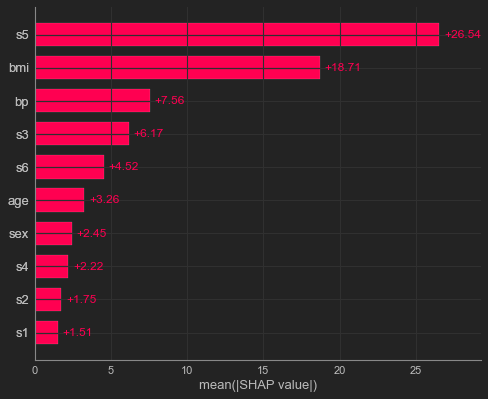

In [20]:
# Plots this view
shap.plots.bar(shap_values)

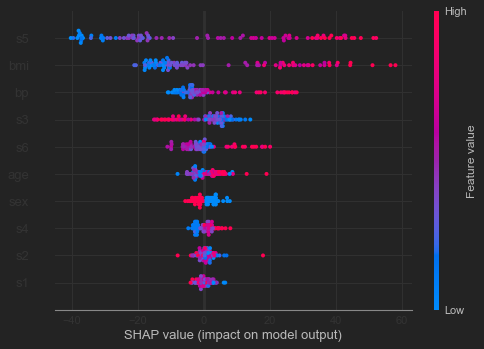

In [21]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values)

## Select features using Boruta

In [22]:
from boruta import BorutaPy

In [23]:
# Defines the estimator used by the Boruta algorithm
estimator = RandomForestRegressor()

In [24]:
# Creates the BorutaPy object
boruta = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100)

In [25]:
# Fits Boruta
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(n_estimators=31,
                                         random_state=RandomState(MT19937) at 0x22BBD84A440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x22BBD84A440)

In [26]:
# Important features
important = list(X.columns[boruta.support_])
print(f"Features confirmed as important: {important}")

# Tentative features
tentative = list(X.columns[boruta.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Unimportant features
unimportant = list(X.columns[~(boruta.support_ | boruta.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['bmi', 'bp', 's3', 's5']
Unconfirmed features (tentative): ['s6']
Features confirmed as unimportant: ['age', 'sex', 's1', 's2', 's4']


In [27]:
X_train_boruta = boruta.transform(np.array(X_train))

In [28]:
X_train_boruta

array([[ 0.06924089,  0.05974393, -0.04708248,  0.10329226],
       [ 0.06169621,  0.02187235, -0.04340085,  0.01990842],
       [-0.00512814, -0.01255635,  0.00814208, -0.00608025],
       ...,
       [-0.03638469,  0.04252958, -0.02683348, -0.0439854 ],
       [ 0.07139652,  0.00121513,  0.01550536, -0.04118039],
       [ 0.05846277,  0.07007254, -0.02131102,  0.02200405]])

## Select features using Boruta-SHAP

In [29]:
from BorutaShap import BorutaShap

In [30]:
# Creates a BorutaShap selector for regression
selector = BorutaShap(importance_measure = 'shap', classification = False)

In [31]:
# Fits the selector
selector.fit(X = X_train, y = y_train, n_trials = 100, sample = False, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['bmi', 'bp', 's3', 's5']
5 attributes confirmed unimportant: ['s1', 's4', 'sex', 'age', 's2']
1 tentative attributes remains: ['s6']


In [32]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(features_to_remove)

['age' 'sex' 's1' 's2' 's4']


In [33]:
# Removes them
X_train_boruta_shap = X_train.drop(columns = features_to_remove)
X_test_boruta_shap = X_test.drop(columns = features_to_remove)

In [34]:
X_train_boruta_shap.head()

,bmi,bp,s3,s5,s6
390,0.069241,0.059744,-0.047082,0.103292,0.073480
0,0.061696,0.021872,-0.043401,0.019908,-0.017646
98,-0.005128,-0.012556,0.008142,-0.006080,-0.067351
279,-0.024529,0.004658,0.015505,-0.015998,-0.025930
100,0.017506,-0.022885,0.030232,0.037232,-0.001078


### Fits a new regression model to the new data

In [35]:
# Prepares a default instance of the random forest regressor
model_new = RandomForestRegressor()

In [36]:
# Fits the model on the data
model_new.fit(X_train_boruta_shap, y_train)

RandomForestRegressor()

In [37]:
# Evaluates the model
y_pred = model_new.predict(X_test_boruta_shap)
evaluate_regression(y_test, y_pred)

Regression result
MAE: 45.52
MSE: 3324.71
RMSE: 57.66
R2: 0.44


In [38]:
# Prints the feature importances
print_feature_importances_random_forest(model_new)

s5 -> 0.4153
bmi -> 0.2435
bp -> 0.1335
s6 -> 0.1067
s3 -> 0.1010


In [39]:
# Fits the explainer
explainer_new = shap.Explainer(model_new.predict, X_test_boruta_shap)

In [40]:
# Calculates the SHAP values - It takes some time
shap_values = explainer_new(X_test_boruta_shap)

In [41]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X_test_boruta_shap.columns)

s5 -> 26.2349 (softmax = 0.9989)
bmi -> 19.4120 (softmax = 0.0011)
bp -> 9.7329 (softmax = 0.0000)
s3 -> 6.6783 (softmax = 0.0000)
s6 -> 4.8357 (softmax = 0.0000)


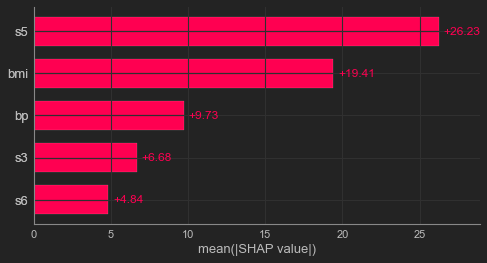

In [42]:
# Plots this view
shap.plots.bar(shap_values)

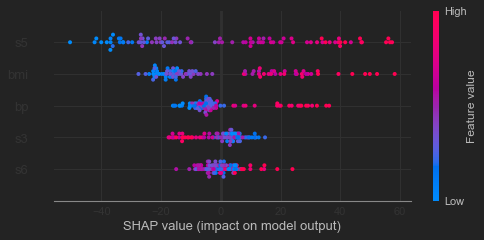

In [43]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values, max_display=14)

## Plots the binomial distribution
For the article

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [45]:
n = 20
p = 0.5

In [46]:
pmf = list(stats.binom.pmf(range(n + 1), n, p))

<AxesSubplot:>

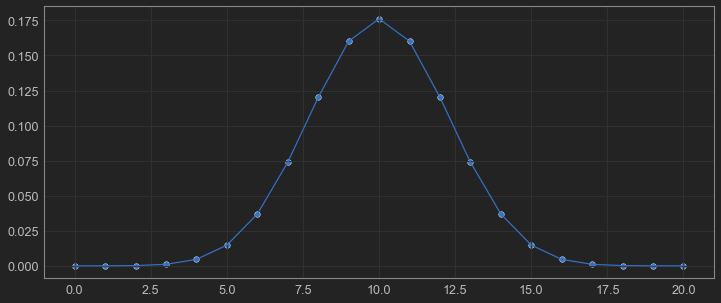

In [47]:
plt.figure(figsize = (12, 5))
sns.scatterplot(x = range(n+1), y = pmf)
sns.lineplot(x = range(n+1), y = pmf)

In [48]:
pmf

[9.5367431640625e-07,
 1.9073486328124993e-05,
 0.00018119812011718736,
 0.0010871887207031228,
 0.004620552062988283,
 0.014785766601562497,
 0.036964416503906236,
 0.07392883300781249,
 0.1201343536376954,
 0.1601791381835938,
 0.17619705200195296,
 0.1601791381835938,
 0.12013435363769538,
 0.07392883300781249,
 0.036964416503906236,
 0.014785766601562497,
 0.004620552062988283,
 0.0010871887207031228,
 0.00018119812011718736,
 1.9073486328124986e-05,
 9.5367431640625e-07]

In [49]:
# In which "point" will we have a cumulative probability of 0.5%?
stats.binom.ppf(0.005, n, p)

4.0

In [50]:
# Confirming:
stats.binom.cdf(4, n, p)

0.005908966064453125

In [51]:
# In which "point" will we have a cumulative probability of 99.5%?
stats.binom.ppf(0.995, n, p)

16.0

In [52]:
# Confirming:
stats.binom.cdf(16, n, p)

0.9987115859985352

#### Final plot

In [53]:
red_border = int(stats.binom.ppf(0.005, n, p))
red_zone = pmf[:red_border+1]

In [54]:
green_border = int(stats.binom.ppf(0.995, n, p))
green_zone = pmf[green_border:]

In [55]:
blue_zone = pmf[red_border:green_border+1]

Text(0.5, 1.0, 'Binomial distribution. p = 0.5; n = 20')

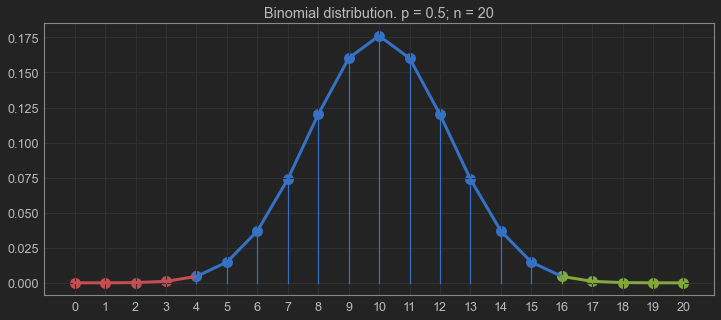

In [56]:
plt.figure(figsize = (12, 5))
# Scatters
sns.scatterplot(x = range(0, red_border+1), y = red_zone, color = 'r', s = 120,  linewidth = 0)
sns.scatterplot(x = range(red_border, green_border+1), y = blue_zone, color = 'b', s = 120,  linewidth = 0)
sns.scatterplot(x = range(green_border, n+1), y = green_zone, color = 'g', s = 120,  linewidth = 0)
# Lines
sns.lineplot(x = range(0, red_border+1), y = red_zone, color = 'r', linewidth = 3)
sns.lineplot(x = range(red_border, green_border+1), y = blue_zone, color = 'b', linewidth = 3)
sns.lineplot(x = range(green_border, n+1), y = green_zone, color = 'g', linewidth = 3)
# Vertical lines
for x, y in zip(range(0, red_border+1), red_zone):
    plt.plot([x, x], [0, y], color = 'r')
for x, y in zip(range(red_border, green_border+1), blue_zone):
    plt.plot([x, x], [0, y], color = 'b')
for x, y in zip(range(green_border, n+1), green_zone):
    plt.plot([x, x], [0, y], color = 'g')
# Plot config
plt.xticks(range(n+1))
plt.title("Binomial distribution. p = 0.5; n = 20")

#### Table for the article

In [57]:
pd.DataFrame(index = ["hits"], data = {"genre" : 3, "audience_score" : 14, "critic_score"  : 20})

,genre,audience_score,critic_score
hits,3,14,20
